# Depth Estimation from Video using MiDaS

This notebook extracts video frames, runs depth estimation using the MiDaS model from PyTorch Hub, and generates 3D point clouds using Open3D.


In [ ]:
!pip install open3d

import cv2
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

In [ ]:
video_path = "/content/sample_data/sample.mp4"
frames_dir = "frames"

if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)


In [ ]:
cap = cv2.VideoCapture(video_path)
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Save frame as image
    frame_path = os.path.join(frames_dir, f'frame_{frame_count:04d}.png')
    cv2.imwrite(frame_path, frame)

    frame_count += 1

cap.release()
print("Frames extracted.")

In [ ]:
cleaned_dir = 'frames_cleaned'

if not os.path.exists(cleaned_dir):
    os.makedirs(cleaned_dir)

In [ ]:
for frame_name in sorted(os.listdir(frames_dir)):
    frame_path = os.path.join(frames_dir, frame_name)
    frame = cv2.imread(frame_path)

    # Resize to 640x480 (or whatever size you choose)
    cleaned_frame = cv2.resize(frame, (640, 480))

    # Save cleaned frame
    cleaned_frame_path = os.path.join(cleaned_dir, frame_name)
    cv2.imwrite(cleaned_frame_path, cleaned_frame)
print("Frames resized.")

In [ ]:
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")  # or midas_v21_small
midas.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
midas.to(device)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


MidasNet(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

In [ ]:
midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')

transform = midas_transforms.dpt_transform  # use _small_transform for midas_v21_small

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
def estimate_depth_midas(frame):
    # Convert to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Apply transform
    input_batch = transform(img).to('cuda' if torch.cuda.is_available() else 'cpu')

    # Run inference
    with torch.no_grad():
        prediction = midas(input_batch)

        # Resize to original frame size
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode='bicubic',
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    return depth_map


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
midas.to(device)

frames_dir = 'frames_cleaned'
depth_dir = 'depth_maps'

# Create output directory if it doesn't exist
if not os.path.exists(depth_dir):
    os.makedirs(depth_dir)

for frame_name in sorted(os.listdir(frames_dir)):
    frame_path = os.path.join(frames_dir, frame_name)
    frame = cv2.imread(frame_path)

    # Convert BGR to RGB
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Apply MiDaS transform
    input_batch = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode='bicubic',
            align_corners=False
        ).squeeze()

    # Convert to numpy and normalize for visualization
    depth_map = prediction.cpu().numpy()
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    depth_map_vis = (255 * (depth_map - depth_min) / (depth_max - depth_min)).astype(np.uint8)

    # Save depth map as image
    depth_map_path = os.path.join(depth_dir, f'depth_{frame_name}')
    cv2.imwrite(depth_map_path, depth_map_vis)

print("Depth maps generated for all frames!")

Depth maps generated for all frames!


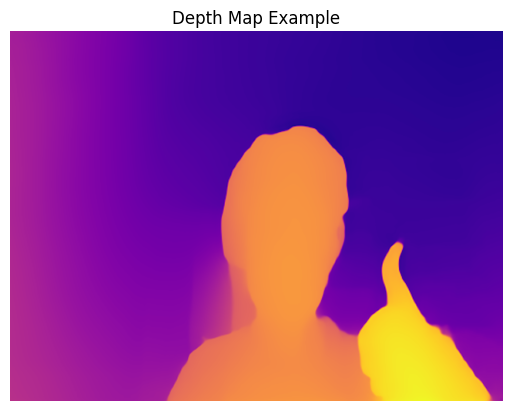

In [ ]:
import matplotlib.pyplot as plt

# Example: display one depth map
depth_example = cv2.imread(os.path.join(depth_dir, sorted(os.listdir(depth_dir))[70]), cv2.IMREAD_GRAYSCALE)

plt.imshow(depth_example, cmap='plasma')
plt.title('Depth Map Example')
plt.axis('off')
plt.show()


In [ ]:
!pip install open3d

In [ ]:
import open3d as o3d
# Example frame and depth map
frame = cv2.imread(os.path.join(frames_dir, sorted(os.listdir(frames_dir))[0]))
depth_map = cv2.imread(os.path.join(depth_dir, sorted(os.listdir(depth_dir))[0]), cv2.IMREAD_GRAYSCALE)

h, w = depth_map.shape
fx = fy = 500
cx = w / 2
cy = h / 2

# Convert depth to float32 (scale if needed)
depth = depth_map.astype(np.float32) / 255.0  # Normalize (if depth_map is 0-255)
depth = depth * 3.0  # Scale depth (arbitrary, adjust for better visualization!)

points = []
colors = []

for v in range(h):
    for u in range(w):
        z = depth[v, u]
        if z == 0:
            continue
        x = (u - cx) * z / fx
        y = (v - cy) * z / fy
        points.append([x, y, z])
        colors.append(frame[v, u] / 255.0)  # RGB colors

# Convert to Open3D PointCloud
pcd = o3d.geometry.PointCloud()


In [ ]:
o3d.io.write_point_cloud("my_point_cloud.ply", pcd)

NameError: name 'pcd' is not defined